# Training a Simple GAN with PyTorch
- GAN for Generating simple MNIST Images
- Good to have a GPU for faster training

In [1]:
!rm -r track
!mkdir track

In [2]:
# Torch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Torchvision Imports
from torchvision import datasets, transforms
from torchvision.utils import save_image

# Device configuration; Good to have a GPU for GAN Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

# Generator Network
- 4 Fully Connected Layers
- Output Dimension will be same as 28*28

In [4]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim, num_classes):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(g_input_dim + num_classes, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, g_output_dim)


    # forward method
    def forward(self, x, y):
        x = torch.cat([x, y.squeeze()], 1)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.2)
        x = F.leaky_relu(self.fc3(x), negative_slope=0.2)
        return torch.tanh(self.fc4(x))


# Discriminator Network
- 4 Fully Connected Layers
- Output is a Single Neuron, 1=Real Image, 0=Fake Image

In [5]:
class Discriminator(nn.Module):
    def __init__(self, d_input_dim, num_classes):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim + num_classes, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)

    # forward method
    def forward(self, x, y):
        x = torch.cat([x, y.squeeze()], 1)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        x = F.dropout(x, p=0.3)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.2)
        x = F.dropout(x, p=0.3)
        x = F.leaky_relu(self.fc3(x), negative_slope=0.2)
        x = F.dropout(x, p=0.3)
        return torch.sigmoid(self.fc4(x))


# Instantiating Models
- Using a random noise of 100 dimensions
- Using BCE Loss for Training
- Using Adam Optimizer for Training

In [6]:
# Models
z_dim = 100 # Dimension of the Input Noise to the Generator
mnist_dim = 28 * 28 # As we have 28x28 pixel images in MNIST
num_classes = 10
G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim, num_classes=num_classes).to(device)
D = Discriminator(mnist_dim,  num_classes=num_classes).to(device)

# loss
criterion = nn.BCELoss()

# optimizer
lr = 0.0002
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

# Loading & Normalizing MNIST Dataset

In [7]:
# Batch Size for Training
batch_size = 100

# Transforming Images to Tensor and then Normalizing the values to be between 0 and 1, with mean 0.5 and std 0.5
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))])

# Loading the Training Dataset and applying Transformation
train_dataset = datasets.MNIST(root='./mnist/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist/', train=False, transform=transform, download=False)

# Data Loader which will be used as input to the models.
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


# Method for Training Discriminator

In [8]:
def train_discriminator(mnist_data_batch, mnist_label_batch):
    #===================Discriminator-Trainer===================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = mnist_data_batch.view(-1, mnist_dim), torch.ones(batch_size, 1)
    x_real, y_real = x_real.to(device), y_real.to(device)
    x_label = torch.nn.functional.one_hot(mnist_label_batch, num_classes=10).to(device)

    # Loss for Real MNIST Data
    D_output = D(x_real, x_label)
    D_real_loss = criterion(D_output, y_real)

    # Generate Data from Generator Network for Training
    z = torch.randn(batch_size, z_dim).to(device) # Random Noise as Input to G
    label = torch.randint(0, 9, (batch_size, 1)).to(device)
    label = torch.nn.functional.one_hot(label, num_classes=10)
    x_fake, y_fake = G(z, label), torch.zeros(batch_size, 1).to(device)

    # Loss for Fake Data from Generator
    D_output = D(x_fake, label)
    D_fake_loss = criterion(D_output, y_fake)

    # Updating only D's weights, so training on D on total loss
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()

    return  D_loss.data.item()


# Method for Training Generator

In [9]:
def train_generator():
    #=======================Generator-Trainer=======================#
    G.zero_grad()

    # Generate Random Noise to use as Input to the Generator
    z = torch.randn(batch_size, z_dim).to(device)
    label = torch.randint(0, 9, (batch_size, 1)).to(device)
    label = torch.nn.functional.one_hot(label, num_classes=10)
    # The final label in this case in 1(True), i.e the Discriminator Model
    # Thinks these are real images therefore the losses for Generator
    # Network should update the weights of G in such a way that it produces more
    # Real looking images.
    y = torch.ones(batch_size, 1).to(device)

    # Generate Images
    G_output = G(z, label)
    # Get output from Discriminator for the Generated Images
    D_output = D(G_output, label)
    # Compute Loss
    G_loss = criterion(D_output, y)

    # Updating only G's weights
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()

# Main Training Loop

In [10]:
# Total number of epochs for Training
n_epoch = 200
n_critic = 3

losses = []

for epoch in range(n_epoch):
    D_losses, G_losses = [], []
    # For Every Batch in the MNIST dataset
    # We train the Discriminator First, then the Generator
    for batch_idx, (mnist_input_data, label) in enumerate(train_loader):
        for _ in range(n_critic):
          D_losses.append(train_discriminator(mnist_input_data, label))
        G_losses.append(train_generator())

    if epoch % 10 == 0:
        test_z = torch.randn(10, z_dim).to(device)
        label_z = torch.Tensor([0,1,2,3,4,5,6,7,8,9]).long().to(device)
        label_z = torch.nn.functional.one_hot(label_z, num_classes=10)
        generated = G(test_z, label_z)
        save_image(generated.view(generated.size(0), 1, 28, 28), f'./track/sample_images_{epoch}' + '.png')

    # Logging the Loss values from Discriminator and Generator
    loss_d = torch.mean(torch.FloatTensor(D_losses))
    loss_g = torch.mean(torch.FloatTensor(G_losses))
    losses.append((loss_d, loss_g))
    print(f'[{epoch}/{n_epoch}]: loss_d: {loss_d}, loss_g: {loss_g}')

[0/200]: loss_d: 0.10644786059856415, loss_g: 8.22718620300293
[1/200]: loss_d: 0.020778769627213478, loss_g: 9.448699951171875
[2/200]: loss_d: 0.036165814846754074, loss_g: 10.291396141052246
[3/200]: loss_d: 0.05740787833929062, loss_g: 8.778903007507324
[4/200]: loss_d: 0.07632704079151154, loss_g: 8.002867698669434
[5/200]: loss_d: 0.10165167599916458, loss_g: 7.431113243103027
[6/200]: loss_d: 0.12869080901145935, loss_g: 6.981318950653076
[7/200]: loss_d: 0.1375935971736908, loss_g: 6.612727165222168
[8/200]: loss_d: 0.19762851297855377, loss_g: 5.689815521240234
[9/200]: loss_d: 0.24561025202274323, loss_g: 5.056235313415527
[10/200]: loss_d: 0.29802098870277405, loss_g: 4.418086051940918
[11/200]: loss_d: 0.35493767261505127, loss_g: 3.956519365310669
[12/200]: loss_d: 0.4085768759250641, loss_g: 3.5331473350524902
[13/200]: loss_d: 0.47234395146369934, loss_g: 3.157463550567627
[14/200]: loss_d: 0.5450807213783264, loss_g: 2.810398578643799
[15/200]: loss_d: 0.593222498893737

# Generating Images from our Trained Generator Network

In [11]:
num_classes

10

In [12]:
with torch.no_grad():
    test_z = torch.randn(8, z_dim).to(device)
    label_z = torch.Tensor([6, 6, 6, 6, 6, 6, 6, 6]).long().to(device)
    label_z = torch.nn.functional.one_hot(label_z, num_classes=10)
    generated = G(test_z, label_z)

    save_image(generated.view(generated.size(0), 1, 28, 28), './sample_images_200' + '.png')

In [ ]:
import matplotlib.pyplot as plt

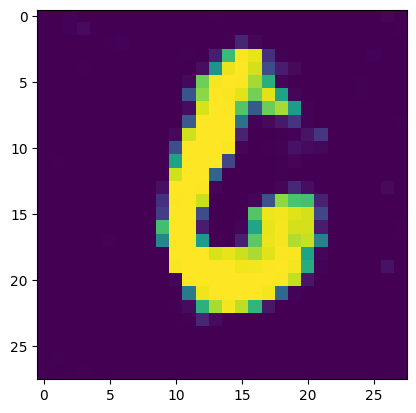

In [ ]:
plt.imshow(generated.view(generated.size(0), 1, 28, 28).cpu()[1].permute(1,2,0))

# Plotting Losses from the Training

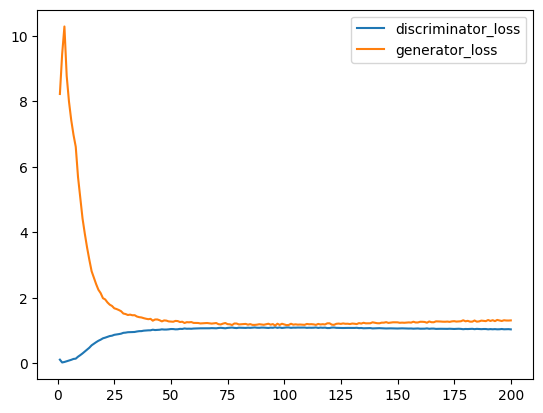

In [14]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(losses)+1), [_[0] for _ in losses], label='discriminator_loss')
plt.plot(range(1, len(losses)+1), [_[1] for _ in losses], label='generator_loss')
plt.legend()
plt.show()